
[Hold-out] 2024-08-31 → 2025-07-31 | model=RandomForest

Arrivals
  RMSE : 28,776.217
  MAE  : 22,286.243
  MAPE : 7.879%
  sMAPE: 8.287%

[Random Forest] horizon=12, lags=12

Forecast results saved to: ../output/Model_04_Forest_IT_ArrivalCount.csv


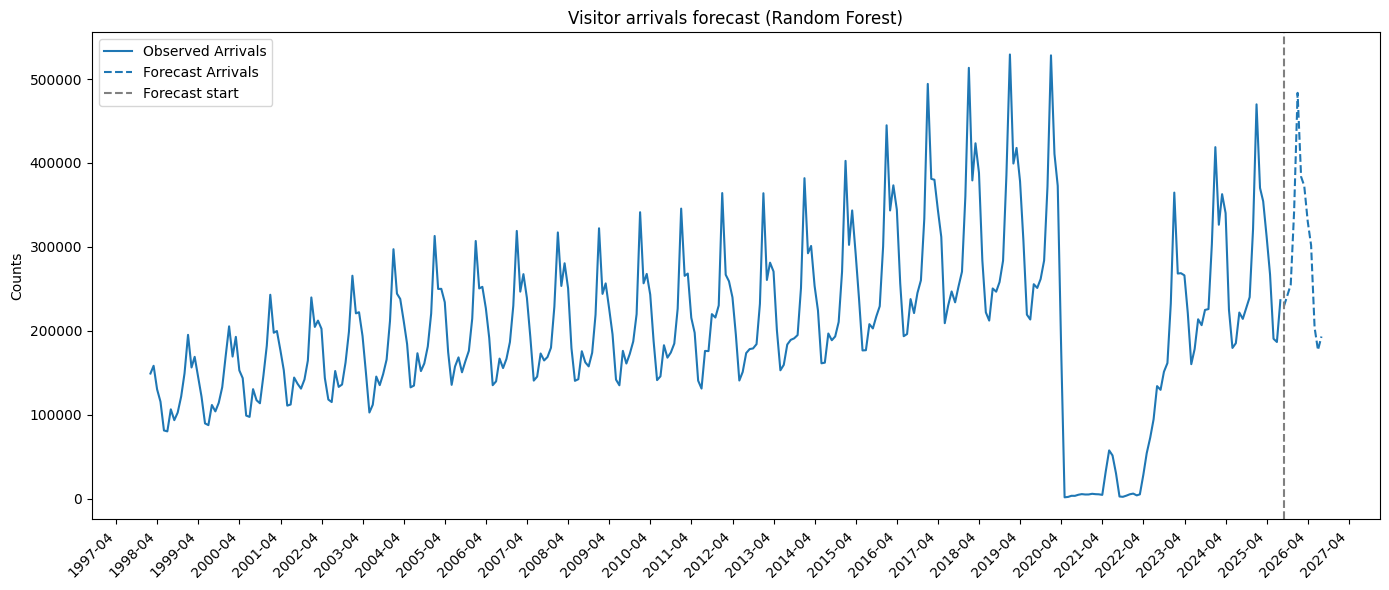

In [2]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.tseries.offsets import MonthEnd
from sklearn.ensemble import RandomForestRegressor

# ----------------------- Config -----------------------
ARRIVALS_CSV = "../datasets/Visitor arrival totals (Monthly).csv"

HORIZON = 12
HOLDOUT_STEPS = 12
N_LAGS = 12   # number of lag months as features

EXCLUDE_RANGES = [
    ("2020-04-30", "2022-02-28"),  # drop COVID border closure
]

SERIES = ["Arrivals"]

# ----------------------- Helpers -----------------------
def full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def print_banner(s):
    bar = "=" * len(s)
    print(f"\n{bar}\n{s}\n{bar}")

# ----------------------- Load Visitor Arrivals -----------------------
def load_arrivals(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    df["Date"] = pd.to_datetime(df["Month"], format="%Y-%m-%d", errors="coerce") + MonthEnd(0)
    df["Arrivals"] = pd.to_numeric(df["Actual Counts"], errors="coerce")

    g = df.groupby("Date")[["Arrivals"]].sum(min_count=1).sort_index()
    idx = full_month_range(g.index)
    g = g.reindex(idx).ffill().bfill()
    return g

# ----------------------- Training window -----------------------
def _mask_exclusions(index: pd.DatetimeIndex) -> pd.Series:
    mask = pd.Series(True, index=index)
    for a, b in EXCLUDE_RANGES:
        a, b = pd.to_datetime(a), pd.to_datetime(b)
        mask[(index >= a) & (index <= b)] = False
    return mask

def apply_training_window(g: pd.DataFrame) -> pd.DataFrame:
    return g[_mask_exclusions(g.index)]

# ----------------------- Transformations -----------------------
def forward_transform(df: pd.DataFrame):
    z = np.log1p(df)
    mu, sd = z.mean(), z.std(ddof=0).replace(0, 1.0)
    z_std = (z - mu) / sd
    return z_std, {"mu": mu, "sd": sd}

def inverse_transform(z_std: pd.DataFrame, meta: dict):
    z = z_std * meta["sd"] + meta["mu"]
    return np.expm1(z).clip(lower=0)

# ----------------------- Feature engineering -----------------------
def make_supervised(series: pd.Series, n_lags: int = 12):
    """Create lagged features + month-of-year dummy."""
    df = pd.DataFrame({"y": series})
    for lag in range(1, n_lags + 1):
        df[f"lag{lag}"] = df["y"].shift(lag)
    df["month"] = df.index.month
    df = pd.get_dummies(df, columns=["month"], drop_first=True)
    return df.dropna()

# ----------------------- Fit Forest -----------------------
def fit_forest_forecast(z_std: pd.Series, horizon: int, n_lags: int = 12):
    df_sup = make_supervised(z_std, n_lags)
    X, y = df_sup.drop(columns=["y"]), df_sup["y"]

    model = RandomForestRegressor(
        n_estimators=500, max_depth=10, random_state=42
    )
    model.fit(X, y)

    # Recursive forecast
    history = z_std.copy()
    preds = []
    last_date = z_std.index[-1]

    for step in range(1, horizon + 1):
        # Build feature row
        lags = [history.iloc[-lag] for lag in range(1, n_lags + 1)]
        row = pd.DataFrame([lags], columns=[f"lag{i}" for i in range(1, n_lags + 1)])
        month = (last_date + pd.DateOffset(months=step)).month
        for m in range(2, 13):  # one-hot months (drop_first=True)
            row[f"month_{m}"] = 1 if month == m else 0

        # Align with training feature space
        row = row.reindex(columns=X.columns, fill_value=0)

        yhat = model.predict(row)[0]
        preds.append(yhat)
        history.loc[last_date + pd.DateOffset(months=step)] = yhat

    fc_idx = pd.date_range(last_date + MonthEnd(1), periods=horizon, freq="M")
    fc = pd.DataFrame({z_std.name: preds}, index=fc_idx)
    return model, fc

# ----------------------- Metrics -----------------------
def _rmse(a, f): return float(np.sqrt(np.mean((a - f) ** 2)))
def _mae(a, f):  return float(np.mean(np.abs(a - f)))
def _mape(a, f):
    a, f = np.asarray(a, dtype=float), np.asarray(f, dtype=float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask] - f[mask]) / a[mask])) * 100) if mask.any() else np.nan
def _smape(a, f):
    a, f = np.asarray(a, dtype=float), np.asarray(f, dtype=float)
    denom = np.abs(a) + np.abs(f)
    mask = denom != 0
    return float(np.mean(2 * np.abs(a[mask] - f[mask]) / denom[mask]) * 100) if mask.any() else np.nan

def print_metrics_block(title, actual: pd.Series, forecast: pd.Series):
    print_banner(title)
    print(f"  RMSE : {_rmse(actual, forecast):,.3f}")
    print(f"  MAE  : {_mae(actual, forecast):,.3f}")
    print(f"  MAPE : {_mape(actual, forecast):.3f}%")
    print(f"  sMAPE: {_smape(actual, forecast):.3f}%")

# ----------------------- Hold-out evaluation -----------------------
def evaluate_holdout(g: pd.DataFrame, holdout_steps: int = HOLDOUT_STEPS):
    if len(g) < (holdout_steps + 36):
        holdout_steps = max(6, len(g) - 36)
    if holdout_steps <= 0:
        return

    train_g, test_g = g.iloc[:-holdout_steps], g.iloc[-holdout_steps:]
    z_std_train, meta_train = forward_transform(train_g)

    model, fc_std = fit_forest_forecast(z_std_train["Arrivals"], holdout_steps, N_LAGS)
    fc_levels = inverse_transform(fc_std, meta_train).reindex(test_g.index)

    print_banner(
        f"[Hold-out] {test_g.index[0].date()} → {test_g.index[-1].date()} | model=RandomForest"
    )
    print_metrics_block("Arrivals", test_g["Arrivals"], fc_levels["Arrivals"])

# ----------------------- Main -----------------------
def main():
    g_all = load_arrivals(ARRIVALS_CSV)
    g_train = apply_training_window(g_all)

    # Holdout metrics
    evaluate_holdout(g_train, holdout_steps=HOLDOUT_STEPS)

    # Fit on full training data & forecast
    z_std, meta = forward_transform(g_train)
    model, fc_std = fit_forest_forecast(z_std["Arrivals"], HORIZON, N_LAGS)
    fc_levels = inverse_transform(fc_std, meta)

    start_fc = fc_levels.index[0]
    print_banner(f"[Random Forest] horizon={HORIZON}, lags={N_LAGS}")

    # Save forecast
    out_csv = "../output/Model_04_Forest_IT_ArrivalCount.csv"
    fc_levels_rounded = fc_levels.round(0).astype(int)
    fc_levels_rounded.index.name = "Date"
    fc_levels_rounded.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(g_all.index, g_all["Arrivals"], label="Observed Arrivals", color="#1f77b4")
    plt.plot(fc_levels.index, fc_levels["Arrivals"], linestyle="--", label="Forecast Arrivals", color="#1f77b4")

    plt.axvline(start_fc, color="gray", linestyle="--", label="Forecast start")
    plt.title("Visitor arrivals forecast (Random Forest)")
    plt.ylabel("Counts")
    plt.legend(loc="upper left", frameon=True)
    configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
